In [1]:
import torch
from torch import nn
import sklearn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
torch.set_float32_matmul_precision('high')
num_classes=9
num_features=4
random_seed=42

# create mutliclass datasets

X_blob,y_blob=make_blobs(n_samples=4000,
                         n_features=num_features,
                         centers=num_classes,
                         cluster_std=1.5,
                         random_state=random_seed)

#Turn data into tensors
X_blob= torch.from_numpy(X_blob).type(torch.float)
y_blob= torch.from_numpy(y_blob).type(torch.LongTensor)

print(X_blob.shape)
print(y_blob.shape)

torch.Size([4000, 4])
torch.Size([4000])


torch.Size([3000, 4])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])


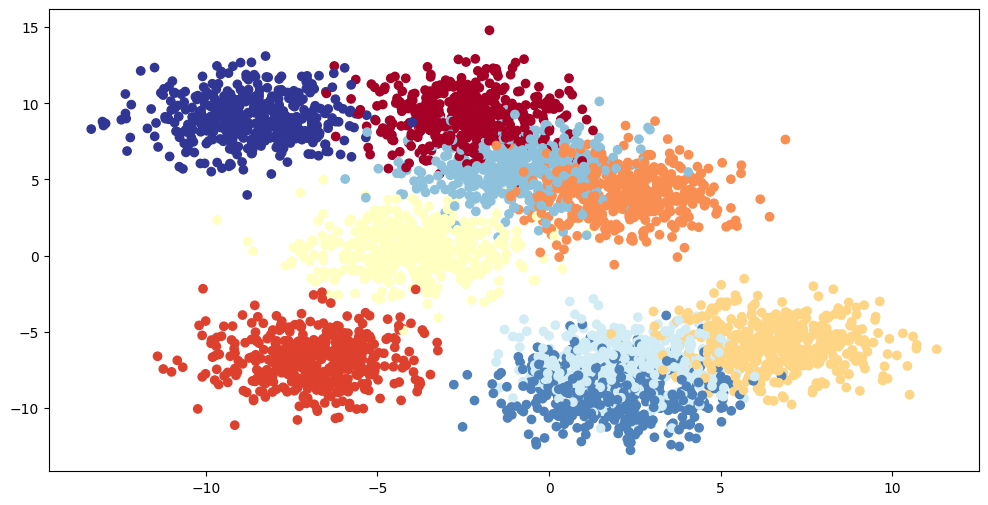

In [3]:
#Split

X_train,X_test,y_train,y_test=train_test_split(X_blob,y_blob, test_size=0.25, random_state=random_seed)

print(X_train.shape)
print(torch.unique(y_train))

# plot data 
plt.figure(figsize=(12,6))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap= plt.cm.RdYlBu)

In [4]:
## Make the model

device= "cuda" if torch.cuda.is_available() else 'cpu'
# device= "cpu"

class BlobModel(nn.Module):
    def __init__ (self, input, output):
        super(). __init__()

        self.layer=nn.Sequential(
            nn.Linear(in_features=input, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=2048),
            nn.ReLU(),
            nn.Linear(in_features=2048, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=output),
        )

    def forward(self,x):
        return self.layer(x)

# model_1=BlobModel(num_features,num_classes).to(device)
model_1=torch.compile(BlobModel(num_features,num_classes)) .to(device)       

In [5]:
## Create accuracy funtion

def accuracy(y_true, y_pred):
    correct= torch.eq(y_true,y_pred).sum().item()
    acc= (correct/len(y_pred))*100
    return acc
    

In [6]:
## Creating loss function

loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [7]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train,y_train = X_train.to(device), y_train.to(device)
X_test, y_test= X_test.to(device), y_test.to(device)

epochs=1000

for epoch in range (epochs):
    ### Training ###
    model_1.train()

    y_logits=model_1(X_train)
    y_preds=torch.softmax(y_logits,dim=1).argmax(dim=1)

    loss=loss_fn(y_logits,y_train)
    acc= accuracy(y_train,y_preds)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing ###
    model_1.eval()
    with torch.inference_mode():
        y_test_logits=model_1(X_test)
        y_test_preds=torch.softmax(y_test_logits, dim=1).argmax(dim=1)

        test_loss= loss_fn(y_test_logits,y_test)
        test_acc=accuracy(y_test, y_test_preds)
        
    if epoch % 100 ==0:
        print(f"|Epochs : {epoch} | Loss : {loss:.4f}  Train_Acc: {acc:.2f}% | Test_loss : {test_loss:.4f}  Test_Acc : {test_acc:.2f}% | ")


W0603 01:28:36.347000 15056 site-packages\torch\_inductor\utils.py:1250] [0/0] Not enough SMs to use max_autotune_gemm mode


|Epochs : 0 | Loss : 2.1983  Train_Acc: 11.23% | Test_loss : 2.2003  Test_Acc : 10.80% | 
|Epochs : 100 | Loss : 2.1842  Train_Acc: 15.70% | Test_loss : 2.1856  Test_Acc : 15.60% | 
|Epochs : 200 | Loss : 1.4088  Train_Acc: 46.80% | Test_loss : 1.3351  Test_Acc : 44.80% | 
|Epochs : 300 | Loss : 0.6787  Train_Acc: 67.13% | Test_loss : 0.6576  Test_Acc : 74.70% | 
|Epochs : 400 | Loss : 0.2060  Train_Acc: 95.60% | Test_loss : 0.2047  Test_Acc : 88.80% | 
|Epochs : 500 | Loss : 0.1150  Train_Acc: 97.20% | Test_loss : 0.1335  Test_Acc : 93.30% | 
|Epochs : 600 | Loss : 0.0410  Train_Acc: 98.87% | Test_loss : 0.0464  Test_Acc : 97.90% | 
|Epochs : 700 | Loss : 0.0403  Train_Acc: 98.70% | Test_loss : 0.0644  Test_Acc : 97.50% | 
|Epochs : 800 | Loss : 1.6704  Train_Acc: 23.40% | Test_loss : 1.6494  Test_Acc : 22.10% | 
|Epochs : 900 | Loss : 0.7638  Train_Acc: 62.30% | Test_loss : 0.7715  Test_Acc : 60.20% | 


In [8]:
# make prediction

model_1.eval()
with torch.inference_mode():
    y_logit=model_1(X_test)
    y_pred= torch.softmax(y_logit, dim=1).argmax(dim=1)

y_pred,y_test

(tensor([4, 7, 3, 7, 7, 2, 1, 6, 7, 7, 6, 8, 1, 5, 2, 5, 8, 6, 4, 8, 7, 6, 8, 0,
         5, 6, 5, 2, 1, 8, 2, 6, 7, 3, 8, 6, 1, 2, 1, 0, 8, 6, 7, 3, 4, 5, 4, 3,
         4, 5, 2, 5, 1, 7, 1, 1, 0, 4, 6, 4, 5, 6, 0, 5, 2, 4, 7, 1, 8, 6, 5, 6,
         8, 7, 3, 7, 7, 3, 0, 4, 2, 0, 3, 3, 7, 4, 3, 7, 4, 5, 5, 5, 1, 2, 1, 6,
         5, 6, 1, 0, 0, 0, 4, 7, 8, 4, 0, 4, 1, 2, 2, 1, 4, 7, 1, 1, 7, 1, 6, 7,
         6, 7, 4, 3, 1, 3, 2, 3, 7, 7, 0, 1, 3, 3, 2, 3, 6, 1, 0, 4, 7, 6, 0, 3,
         2, 2, 1, 5, 2, 0, 2, 6, 8, 5, 5, 2, 6, 2, 8, 5, 8, 8, 5, 2, 7, 8, 3, 3,
         3, 5, 3, 0, 1, 3, 7, 2, 7, 7, 8, 5, 1, 1, 0, 1, 5, 1, 0, 5, 0, 1, 7, 8,
         0, 3, 4, 4, 1, 7, 3, 7, 8, 8, 3, 6, 8, 5, 8, 1, 8, 2, 5, 3, 6, 5, 3, 6,
         4, 2, 4, 4, 4, 5, 3, 6, 2, 4, 8, 5, 3, 8, 5, 6, 0, 2, 7, 6, 1, 7, 1, 0,
         3, 5, 3, 4, 3, 2, 5, 0, 0, 0, 5, 7, 8, 1, 4, 8, 6, 3, 4, 6, 7, 0, 8, 7,
         6, 6, 8, 5, 2, 8, 7, 5, 3, 8, 8, 3, 2, 6, 4, 0, 4, 0, 4, 8, 3, 4, 6, 8,
         6, 5, 0, 3, 7, 0, 3

In [9]:
import requests

from pathlib import Path

if Path('helper_functions.py').is_file():
    print ('This exists')

else:
    print("Downloading")
    request=requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py')

    with open('helper_functions.py','wb') as f:
        f.write(request.content)

from helper_functions import plot_decision_boundary, plot_predictions



This exists


In [10]:
X_train.shape, y_train.shape

(torch.Size([3000, 4]), torch.Size([3000]))

In [11]:

# plt.figure(figsize=(12,6))
# plt.subplot(1,2,1)
# plt.title("Train")
# plot_decision_boundary(model_1, X_train,y_train)
# plt.subplot(1,2,2)
# plt.title('Test')
# plot_decision_boundary(model_1, X_test,y_test)

In [12]:
y_pred==y_test

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, 

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,accuracy_score

conf_matrix= confusion_matrix(y_test.cpu(), y_pred.cpu())
conf_matrix


array([[114,   0,   0,   0,   0,   0,   0,   0,   3],
       [  0, 108,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 112,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 111,   0,   0,   0,   0,   0],
       [  1,   0,   0,   0, 100,   0,   0,   0,   0],
       [  0,   0,   0,  11,   0,  88,   0,  17,   0],
       [  0,   0,   0,   0,   0,   0,  93,   0,   2],
       [  0,   0,   0,   0,   0,   6,   0, 117,   0],
       [  2,   0,   0,   0,   0,   0,   0,   0, 115]])

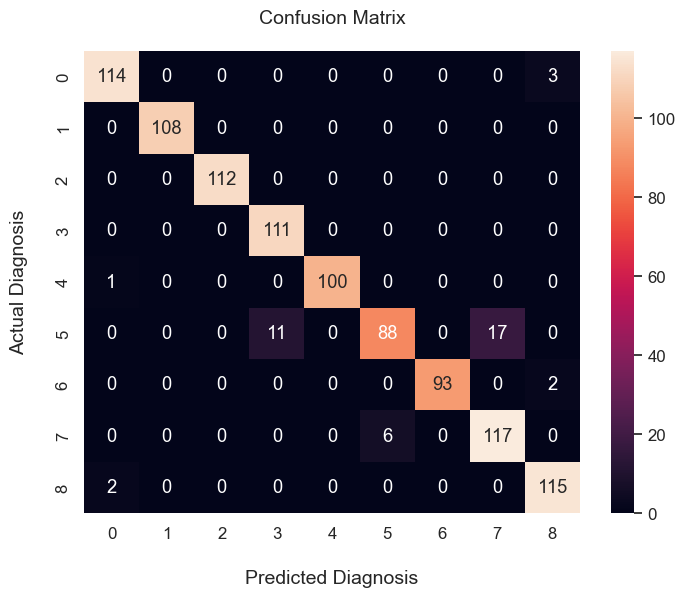

In [14]:
import seaborn as sns
 
# Change figure size and increase dpi for better resolution
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)
 
# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', )
 
# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)

 
# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)

 
# set plot title
ax.set_title("Confusion Matrix", fontsize=14, pad=20)
 
plt.show()

In [15]:
Accuracy=accuracy_score(y_test.cpu(),y_pred.cpu())*100
print(f"{Accuracy}%")

95.8%


In [16]:
 # accuracy
# import torchmetrics
# from torchmetrics import Accuracy

# torch_acc=Accuracy(task='multiclass',num_classes=num_classes).to(device)

# torch_acc(y_pred,y_test) #(input, target)